In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import gc
import time
from sklearn.model_selection import GridSearchCV
import matplotlib.cm as cm

In [2]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-7build1).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge                                                          1 file, 77912192 bytes (75 MiB)

Extracting archive: /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
--
Path = /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      3% - train.t                7% - train.t               11% - train.t               14% - train.t               17% 

In [3]:
df = pd.read_csv("train.tsv", low_memory=False, sep='\t')

In [4]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ
summary(df)

data shape: (1482535, 8)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
train_id,int64,0,0.000000,1482535,0.0,1482534.0,0,1,2
name,object,0,0.000000,1225273,NaN,NaN,MLB Cincinnati Reds T Shirt Size XL,Razer BlackWidow Chroma Keyboard,AVA-VIV Blouse
item_condition_id,int64,0,0.000000,5,1.0,5.0,3,3,1
category_name,object,6327,0.426769,1287,NaN,NaN,Men/Tops/T-shirts,Electronics/Computers & Tablets/Components & P...,Women/Tops & Blouses/Blouse
brand_name,object,632682,42.675687,4809,NaN,NaN,NaN,Razer,Target
price,float64,0,0.000000,828,0.0,2009.0,10.0,52.0,10.0
shipping,int64,0,0.000000,2,0.0,1.0,1,0,1
item_description,object,4,0.000270,1281426,NaN,NaN,No description yet,This keyboard is in great condition and works ...,Adorable top with a hint of lace and a key hol...


In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.shape, test.shape

((1186028, 8), (296507, 8))

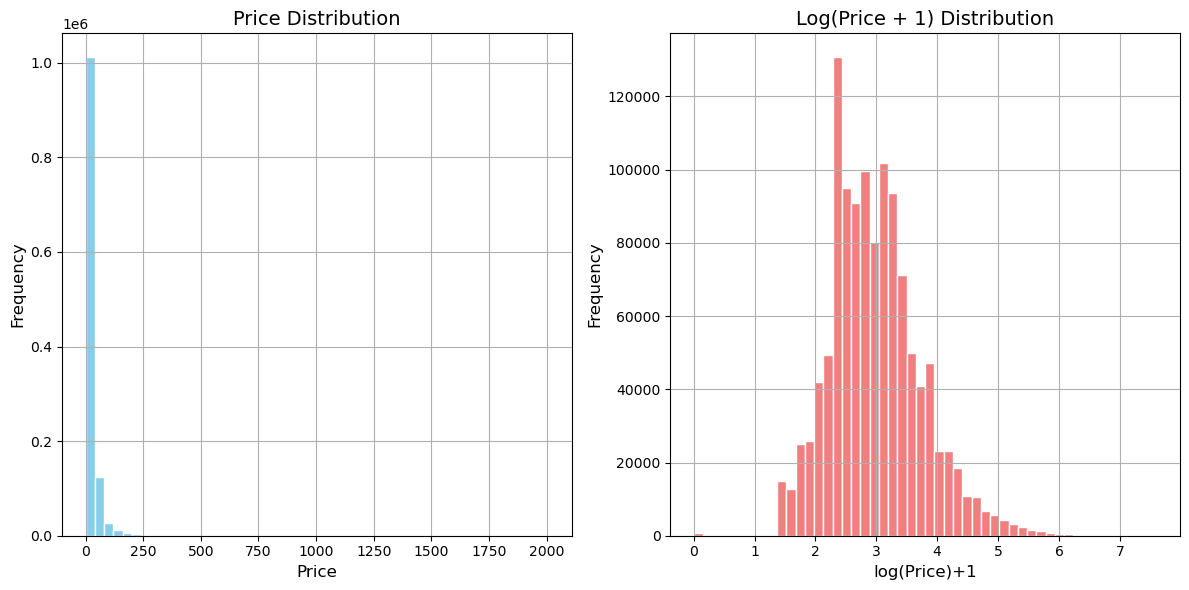

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train['price'], bins=50, edgecolor='white', color='skyblue')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Price Distribution', fontsize=14)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(np.log(train['price'] + 1), bins=50, edgecolor='white', color='lightcoral')
plt.xlabel('log(Price)+1', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Log(Price + 1) Distribution', fontsize=14)
plt.grid(True)

plt.tight_layout()

plt.show()

In [8]:
train['shipping'].value_counts()/len(train) *100

0    55.28318
1    44.71682
Name: shipping, dtype: float64

In [9]:
fee_buyer = train.loc[df['shipping'] ==0, 'price']
fee_seller = train.loc[df['shipping']==1, 'price']
print("The avg. Price is {}".format(round(fee_seller.mean(), 2)), "when seller pays the shipping");
print("The avg. Price is {}".format(round(fee_buyer.mean(), 2)), "when buyer pays the shipping")

The avg. Price is 22.53 when seller pays the shipping
The avg. Price is 30.07 when buyer pays the shipping


In [10]:
train['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

<AxesSubplot:xlabel='item_condition_id', ylabel='price'>

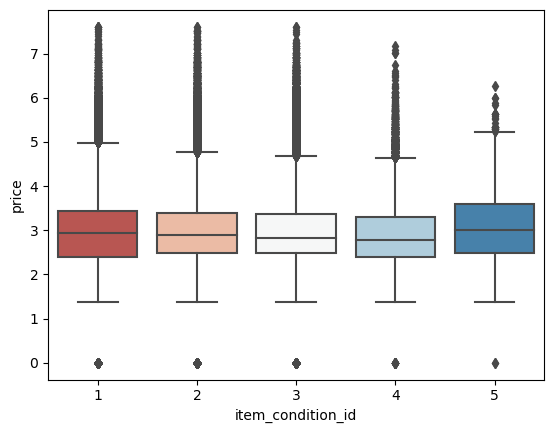

In [11]:
sns.boxplot(x = 'item_condition_id', y =np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

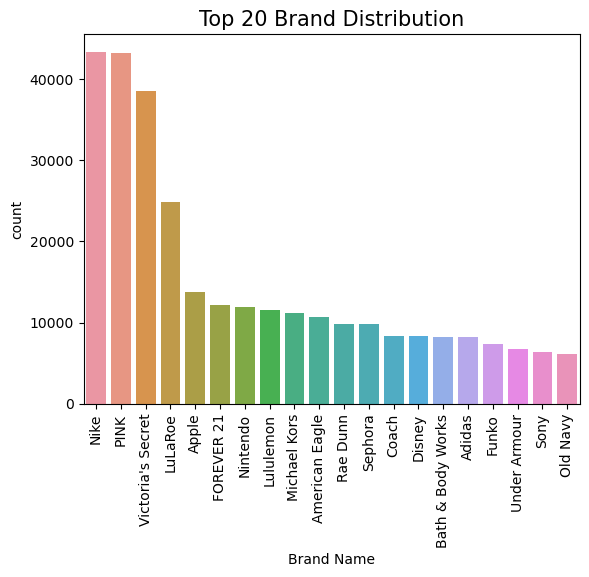

In [12]:
b20 = train['brand_name'].value_counts()[0:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
ax.set_xlabel('Brand Name')
plt.show()

In [13]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 500000

In [14]:
train['category_name'].isnull().sum()

5083

In [15]:
train['brand_name'].isnull().sum()

506058

In [16]:
train['item_description'].isnull().sum()

3

In [17]:
train['price'].isnull().sum()

0

In [18]:
train['item_condition_id'].isnull().sum()

0

In [19]:
def heandel_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet,''missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)
    
    
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

    
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [20]:
df = pd.read_csv("train.tsv", sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price !=0].reset_index(drop=True)

In [21]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [22]:
heandel_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [23]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
x_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
x_category = cv.fit_transform(merge['category_name'])

In [24]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [25]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [26]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [27]:
sparse_merge = hstack((X_dummies, X_description, X_brand, x_category, x_name)).tocsr()

In [28]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) -1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [29]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [30]:
train_X =lgb.Dataset(X, label=y)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'num_leaves': [50, 100, 150],
}

gbm = lgb.LGBMRegressor(application='regression', metric='RMSE', verbosity=-1)

grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_params = grid_search.best_params_
gbm = lgb.LGBMRegressor(application='regression', metric='RMSE', verbosity=-1, **best_params)
gbm.fit(X, y)

y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

train_sizes, train_scores, test_scores = learning_curve(
    gbm, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Error')
plt.xlabel('Training Size')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='best')
plt.title('Learning Curve')
plt.show()